this notebook covers topics where I noticed confusion in class, during office hours, or in questions students asked about the extra credit projects.

In general, remember to comment on what you do, download data programmatically, store in your os.getenv(PUIDATA) directory, have axis labels and captions for your figure and discuss your findings task by task (in the figures and in markdown cells)

In [1]:
#initial imports
import pylab as pl
import pandas as pd

#added to use the env variable PUI
import os

#added to get data from the internet
import urllib
import requests

#geospatial imports
import geopandas as gp
import shapely
from fiona.crs import from_epsg

#for modeling
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# getting data from NYC.gov, 
the Open Data portal has many files. csv files can be accessed directly from the link

In [2]:
firehouses = pd.read_csv("https://data.cityofnewyork.us/api/views/hc8x-tcnd/rows.csv?accessType=DOWNLOAD")

inpect your data!

In [3]:
firehouses.head()

,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,Engine 4/Ladder 15,42 South Street,Manhattan,10005.0,40.703466,-74.007538,1.0,1.0,7.0,1000867.0,1.000350e+09,Battery Park City-Lower Manhattan ...
1,Engine 10/Ladder 10,124 Liberty Street,Manhattan,10006.0,40.710072,-74.012523,1.0,1.0,13.0,1075700.0,1.000520e+09,Battery Park City-Lower Manhattan ...
2,Engine 6,49 Beekman Street,Manhattan,10038.0,40.710048,-74.005245,1.0,1.0,1501.0,1001287.0,1.000930e+09,Battery Park City-Lower Manhattan ...
3,Engine 7/Ladder 1/Battalion 1/Manhattan Boroug...,100-104 Duane Street,Manhattan,10007.0,40.715463,-74.005938,1.0,1.0,33.0,1001647.0,1.001500e+09,SoHo-TriBeCa-Civic Center-Little Italy ...
4,Ladder 8,14 North Moore Street,Manhattan,10013.0,40.719759,-74.006678,1.0,1.0,33.0,1002150.0,1.001890e+09,SoHo-TriBeCa-Civic Center-Little Italy ...


In [4]:
firehouses.tail()

,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
213,Engine 162/Ladder 82/Battalion 23,256 Nelson Avenue,Staten Island,10308.0,40.543205,-74.147097,3.0,51.0,15601.0,5067428.0,5.052710e+09,Great Kills ...
214,Engine 167/Ladder 87,345 Annadale Road,Staten Island,10312.0,40.554174,-74.175809,3.0,51.0,17012.0,5075428.0,5.056420e+09,Annadale-Huguenot-Prince's Bay-Eltingville ...
215,Engine 164/Ladder 84,1560 Drumgoole Road West,Staten Island,10312.0,40.535332,-74.195611,3.0,51.0,20804.0,5083491.0,5.068280e+09,Rossville-Woodrow ...
216,Engine 168/EMS Station 23,1100 Rossville Avenue,Staten Island,10309.0,40.553977,-74.212812,3.0,51.0,20801.0,5154879.0,5.070670e+09,Rossville-Woodrow ...
217,Engine 151/Ladder 76,7219 Amboy Road,Staten Island,10307.0,40.512518,-74.238822,3.0,51.0,248.0,5089056.0,5.080400e+09,Charleston-Richmond Valley-Tottenville ...


In [5]:
firehouses.shape


(218, 12)

In [6]:
firehouses.columns

Index(['FacilityName', 'FacilityAddress', 'Borough', 'Postcode', 'Latitude',
       'Longitude', 'Community Board', 'Community Council ', 'Census Tract',
       'BIN', 'BBL', 'NTA'],
      dtype='object')

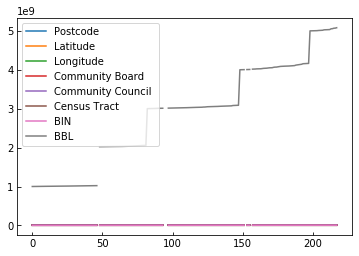

In [7]:
firehouses.plot()

In [8]:
# this is a nonsense plot, if I want a map I need my data to be geospatial (e.g. a GeoDF)

# turning a DF with some spatial (point) info into a geoDF

In [9]:
firehouses['lonlat'] = list(zip(firehouses.Longitude, firehouses.Latitude))

In [10]:
firehouses['geometry'] = firehouses[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [11]:
firehouses = gp.GeoDataFrame(firehouses)

now I can plot it

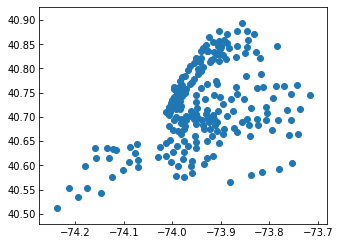

In [12]:
firehouses.plot()

the plot above is awful!: i need axis labels, or to drop the axes, and I need context: the NYC boundaries

# Getting the Boroughs shape file from NYC Open Data

In [13]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")



('file.gz', <http.client.HTTPMessage at 0x1269b6da0>)

In [171]:
!unzip -d $PUIDATA file.gz


Archive:  file.gz
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_95a1b28f-71e9-4a29-9771-fc3936e36860.dbf  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_95a1b28f-71e9-4a29-9771-fc3936e36860.shp  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_95a1b28f-71e9-4a29-9771-fc3936e36860.shx  
  inflating: /Users/fbb/Dropbox//UI/PUIdata/geo_export_95a1b28f-71e9-4a29-9771-fc3936e36860.prj  


In [14]:
boro = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                 "/geo_export_95a1b28f-71e9-4a29-9771-fc3936e36860.shp")

(-74.28337047811617, -73.67222994890714, 40.47514452612885, 40.936503645041554)

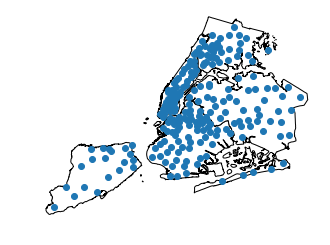

In [15]:
ax = boro.plot(facecolor="w", edgecolor="k")
firehouses.plot(ax=ax)
ax.axis('off')

CAPTION HERE!!

If I want to do do spatial joins or any other spatial manipulation which requires calculating distances I want to move to a planar cooridnate system that supports Eucledian geometry. We want to cinvert both from lat-lon degrees of angle coordinates to the State Plane coordinate system. *boro* has a coordinate system linked to it cause I downloaded the shapefile. *firehouses* does not cause I just made the geospatial column from numbers in the dataframe, I need to give it a coordinate system yet. 

converting *boro* to planar (state plane) geometry

In [16]:
boro.to_crs(epsg=2263, inplace=True)

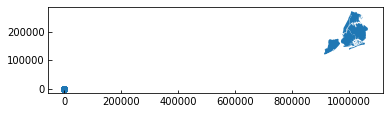

In [17]:
ax = boro.plot()
firehouses.plot(ax=ax)

*firehouses* has no coordinate system assigned yet so I cannot conver it

In [18]:
firehouses.to_crs(epsg=2263)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

assign the lat-lon coordinate system

In [19]:
firehouses.crs = from_epsg(4326)

convert to State-Plane

In [20]:
firehouses.to_crs(epsg=2263, inplace=True)

(905464.7390380861, 1075092.8783935562, 112485.76063499587, 280480.41425937944)

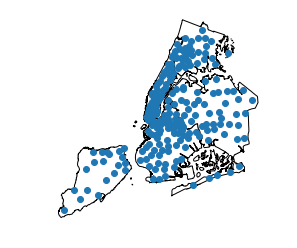

In [21]:
ax = boro.plot(facecolor="w", edgecolor="k")
firehouses.plot(ax=ax)
ax.axis('off')

CAPTION

In [22]:
firehouses.shape

(218, 14)

In [23]:
boro.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...
1,2.0,Bronx,1.186615e+09,463464.521828,(POLYGON ((1012821.805786134 229228.2645873486...
2,5.0,Staten Island,1.623921e+09,330432.867999,(POLYGON ((970217.0223998993 145643.3322142987...
3,3.0,Brooklyn,1.937567e+09,739945.437431,(POLYGON ((1021176.479003908 151374.7969970215...
4,4.0,Queens,3.044772e+09,895228.960360,(POLYGON ((1029606.076599121 156073.8142089235...


# spatial join: find how many firehouses per borough

In [26]:
borofh = gp.sjoin(boro, firehouses, op="contains")

In [27]:
borofh

,boro_code,boro_name,shape_area,shape_leng,geometry,index_right,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA,lonlat
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,0,Engine 4/Ladder 15,42 South Street,Manhattan,10005.0,40.703466,-74.007538,1.0,1.0,7.0,1000867.0,1.000350e+09,Battery Park City-Lower Manhattan ...,"(-74.007538, 40.703466)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,2,Engine 6,49 Beekman Street,Manhattan,10038.0,40.710048,-74.005245,1.0,1.0,1501.0,1001287.0,1.000930e+09,Battery Park City-Lower Manhattan ...,"(-74.005245, 40.710048)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,1,Engine 10/Ladder 10,124 Liberty Street,Manhattan,10006.0,40.710072,-74.012523,1.0,1.0,13.0,1075700.0,1.000520e+09,Battery Park City-Lower Manhattan ...,"(-74.012523, 40.710072)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,5,Engine 9/Ladder 6,75 Canal Street,Manhattan,10002.0,40.715213,-73.992901,3.0,1.0,16.0,1003898.0,1.003000e+09,Chinatown ...,"(-73.992901, 40.715213)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,3,Engine 7/Ladder 1/Battalion 1/Manhattan Boroug...,100-104 Duane Street,Manhattan,10007.0,40.715463,-74.005938,1.0,1.0,33.0,1001647.0,1.001500e+09,SoHo-TriBeCa-Civic Center-Little Italy ...,"(-74.005938, 40.715463)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,6,Engine 15/Ladder 18/Battalion 4,25 Pitt Street,Manhattan,10002.0,40.716395,-73.983478,3.0,1.0,12.0,1004078.0,1.003420e+09,Lower East Side ...,"(-73.983478, 40.716395)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,4,Ladder 8,14 North Moore Street,Manhattan,10013.0,40.719759,-74.006678,1.0,1.0,33.0,1002150.0,1.001890e+09,SoHo-TriBeCa-Civic Center-Little Italy ...,"(-74.00667800000001, 40.719759)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,9,Engine 55,363 Broome Street,Manhattan,10013.0,40.720033,-73.995689,2.0,1.0,41.0,1066722.0,1.004700e+09,SoHo-TriBeCa-Civic Center-Little Italy ...,"(-73.995689, 40.720033)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,7,Engine 28/Ladder 11,222 East 2nd Street,Manhattan,10009.0,40.721682,-73.982622,3.0,2.0,2202.0,1004608.0,1.003850e+09,Lower East Side ...,"(-73.98262199999999, 40.721682)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,10,Ladder 20/Division 1,253 Lafayette Street,Manhattan,10012.0,40.723072,-73.996804,2.0,1.0,43.0,1007523.0,1.004950e+09,SoHo-TriBeCa-Civic Center-Little Italy ...,"(-73.996804, 40.723071999999995)"


In [28]:
borofh.shape

(212, 19)

In [29]:
firehouses.shape

(218, 14)

keep track of the data you loose in any join and merge! 

In [61]:
print("we lost {:.1f} per cent of the data ({:d} fire houses) in the merge".format(
    (firehouses.shape[0] - borofh.shape[0]) / firehouses.shape[0] * 100, 
    firehouses.shape[0] - borofh.shape[0]))

we lost 2.8 per cent of the data (6 fire houses) in the merge


counting the number of firehouses per boro with groupby

In [51]:
borofh.groupby('boro_code').count()

,boro_name,shape_area,shape_leng,geometry,index_right,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA,lonlat
boro_code,,,,,,,,,,,,,,,,,,
1.0,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
2.0,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
3.0,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
4.0,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
5.0,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


(905464.7390380861, 1075092.8783935562, 112485.76063499587, 280480.41425937944)

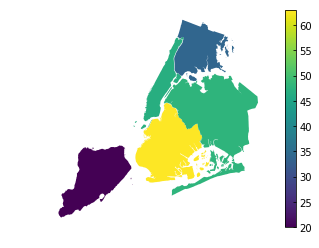

In [49]:
ax = boro.merge(borofh.groupby('boro_code').count()[['boro_name']].reset_index(), 
                on="boro_code").plot(column="boro_name_y", legend=True)
ax.axis('off')


this is not a great plot: with 4 only value the continuous color bar does not easily allow one to read the exact number of firehouses per borough.

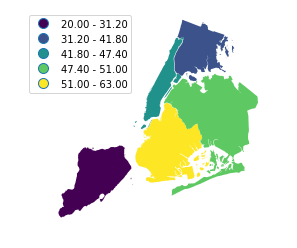

In [50]:
ax = boro.merge(borofh.groupby('boro_code').count()[['boro_name']].reset_index(), 
                on="boro_code").plot(column="boro_name_y", scheme="quantiles", legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.8, 0.2, 0.2))


this is also not great, but a bit better. I moved the legend cause it was overlapping the plot in the default location

# modeling

In [104]:
# reading in the PLUTO mahnattan data
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

In [105]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,10515,None,0.000000e+00,None,1,16v1,0,260.428942,2867.154706,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,10302,None,1.007230e+09,11/30/2006,1,16v1,7,417.764545,10907.639931,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,10605,None,0.000000e+00,None,1,16v1,0,256.893308,2665.033424,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,MN,1385,32,108,130,2003,02,4,10021,E039,...,10508,None,0.000000e+00,None,1,16v1,0,505.033271,15302.920916,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,MN,1197,27,107,169,5000,03,6,10024,E074,...,10408,None,0.000000e+00,None,1,16v1,0,295.652483,4374.612455,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [106]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDist', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'LtdHeight', 'AllZoning1', 'AllZoning2',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptLand', 'ExemptTot', 'YearBuilt', 'BuiltCode', 'YearAlter1',
       'YearAlter2', 'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR',
       'FacilFAR', 'BoroCode', 'BBL', 'CondoNo', 'T

extracting numerical features

get the zipcode data: demographics by zipcode on the NYC open data website

In [109]:
zcs = pd.read_csv("https://data.cityofnewyork.us/api/views/kku6-nxdu/rows.csv?accessType=DOWNLOAD")

In [110]:
zcs.head()

,JURISDICTION NAME,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,...,COUNT CITIZEN STATUS TOTAL,PERCENT CITIZEN STATUS TOTAL,COUNT RECEIVES PUBLIC ASSISTANCE,PERCENT RECEIVES PUBLIC ASSISTANCE,COUNT NRECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,COUNT PUBLIC ASSISTANCE UNKNOWN,PERCENT PUBLIC ASSISTANCE UNKNOWN,COUNT PUBLIC ASSISTANCE TOTAL,PERCENT PUBLIC ASSISTANCE TOTAL
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,44,100,20,0.45,24,0.55,0,0,44,100
1,10002,35,19,0.54,16,0.46,0,0,35,100,...,35,100,2,0.06,33,0.94,0,0,35,100
2,10003,1,1,1.00,0,0.00,0,0,1,100,...,1,100,0,0.00,1,1.00,0,0,1,100
3,10004,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0,0.00,0,0.00,0,0,0,0
4,10005,2,2,1.00,0,0.00,0,0,2,100,...,2,100,0,0.00,2,1.00,0,0,2,100


In [111]:
zcs.columns

Index(['JURISDICTION NAME', 'COUNT PARTICIPANTS', 'COUNT FEMALE',
       'PERCENT FEMALE', 'COUNT MALE', 'PERCENT MALE', 'COUNT GENDER UNKNOWN',
       'PERCENT GENDER UNKNOWN', 'COUNT GENDER TOTAL', 'PERCENT GENDER TOTAL',
       'COUNT PACIFIC ISLANDER', 'PERCENT PACIFIC ISLANDER',
       'COUNT HISPANIC LATINO', 'PERCENT HISPANIC LATINO',
       'COUNT AMERICAN INDIAN', 'PERCENT AMERICAN INDIAN',
       'COUNT ASIAN NON HISPANIC', 'PERCENT ASIAN NON HISPANIC',
       'COUNT WHITE NON HISPANIC', 'PERCENT WHITE NON HISPANIC',
       'COUNT BLACK NON HISPANIC', 'PERCENT BLACK NON HISPANIC',
       'COUNT OTHER ETHNICITY', 'PERCENT OTHER ETHNICITY',
       'COUNT ETHNICITY UNKNOWN', 'PERCENT ETHNICITY UNKNOWN',
       'COUNT ETHNICITY TOTAL', 'PERCENT ETHNICITY TOTAL',
       'COUNT PERMANENT RESIDENT ALIEN', 'PERCENT PERMANENT RESIDENT ALIEN',
       'COUNT US CITIZEN', 'PERCENT US CITIZEN', 'COUNT OTHER CITIZEN STATUS',
       'PERCENT OTHER CITIZEN STATUS', 'COUNT CITIZEN STATUS UNKN

when you merge 2 files remember to check that the commin column has the same values **and** the same data type

In [112]:
zcs["JURISDICTION NAME"].dtype

dtype('int64')

In [113]:
bsize.ZipCode.dtype

dtype('int64')

In [114]:
#merging building data with zipcode data
zcs.merge(bsize, right_on="ZipCode", left_on="JURISDICTION NAME")

,JURISDICTION NAME,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,...,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,10302,None,1.007230e+09,11/30/2006,1,16v1,7,417.764545,10907.639931,"POLYGON ((984164.5626000017 211846.0703999996,..."
1,10001,44,22,0.50,22,0.50,0,0,44,100,...,10305,None,0.000000e+00,None,1,16v1,0,333.668811,6722.064807,"POLYGON ((986344.9013999999 210752.8860000074,..."
2,10001,44,22,0.50,22,0.50,0,0,44,100,...,10305,None,0.000000e+00,None,1,16v1,0,252.066692,2374.028179,"POLYGON ((987154.9971999973 212662.8618000001,..."
3,10001,44,22,0.50,22,0.50,0,0,44,100,...,10305,None,0.000000e+00,None,1,16v1,0,249.818683,2407.133401,"POLYGON ((986497.3799999952 211436.4702000022,..."
4,10001,44,22,0.50,22,0.50,0,0,44,100,...,10304,E-276,0.000000e+00,None,1,16v1,0,255.995297,2674.646205,"POLYGON ((985620.0530000031 212216.0470000058,..."
5,10001,44,22,0.50,22,0.50,0,0,44,100,...,10304,None,1.007780e+09,01/03/2008,1,16v1,7,376.436683,8707.318830,"POLYGON ((985487.1976000071 211967.9906000048,..."
6,10001,44,22,0.50,22,0.50,0,0,44,100,...,10305,None,1.008010e+09,08/15/2012,1,16v1,7,360.168621,7918.460753,"POLYGON ((986177.5085999966 210732.4828000069,..."
7,10001,44,22,0.50,22,0.50,0,0,44,100,...,10302,None,0.000000e+00,None,1,16v1,0,1115.406398,67144.640450,"POLYGON ((983772.1322000027 212181.6542000026,..."
8,10001,44,22,0.50,22,0.50,0,0,44,100,...,10303,None,0.000000e+00,None,1,16v1,7,247.871928,2162.216088,"POLYGON ((984991.9849999994 212566.2494000047,..."
9,10001,44,22,0.50,22,0.50,0,0,44,100,...,10303,None,0.000000e+00,None,1,16v1,0,261.788802,2355.743055,"POLYGON ((985385.0895999968 212349.7691999972,..."


In [115]:
# counting the buildings by zipcode
bsize.groupby("ZipCode").count()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,FireComp,PolicePrct,...,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
ZipCode,,,,,,,,,,,,,,,,,,,,,
0,136,136,136,136,21,1,55,136,35,136,...,129,1,136,16,136,136,136,136,136,136
10001,1001,1001,1001,1001,1001,995,1001,1001,1001,1001,...,1000,174,1001,125,1001,1001,1001,1001,1001,1001
10002,1689,1689,1689,1689,1689,1681,1689,1689,1689,1689,...,1687,150,1689,203,1689,1689,1689,1689,1689,1689
10003,1869,1869,1869,1869,1868,1867,1868,1869,1869,1869,...,1868,139,1869,202,1869,1869,1869,1869,1869,1869
10004,113,113,113,113,113,112,113,113,113,113,...,113,0,113,26,113,113,113,113,113,113
10005,75,75,75,75,75,74,75,75,74,75,...,74,0,75,15,75,75,75,75,75,75
10006,66,66,66,66,66,66,66,66,66,66,...,66,0,66,14,66,66,66,66,66,66
10007,231,231,231,231,231,227,231,231,231,231,...,231,2,231,71,231,231,231,231,231,231
10009,1316,1316,1316,1316,1316,1313,1316,1316,1316,1316,...,1315,175,1316,152,1316,1316,1316,1316,1316,1316


In [116]:
bcount = bsize.groupby("ZipCode").count()[["Borough"]].reset_index().rename(columns={"Borough":"Nbuild"})
bcount

,ZipCode,Nbuild
0,0,136
1,10001,1001
2,10002,1689
3,10003,1869
4,10004,113
5,10005,75
6,10006,66
7,10007,231
8,10009,1316
9,10010,612


In [117]:
bcount = bcount.merge(zcs, left_on="ZipCode", right_on="JURISDICTION NAME")[["Nbuild", 'COUNT PARTICIPANTS',
                                        'PERCENT WHITE NON HISPANIC',
                                       'PERCENT US CITIZEN', 'COUNT RECEIVES PUBLIC ASSISTANCE']]


In [120]:
bcount.rename(columns={'COUNT PARTICIPANTS':"ppl",
                    'PERCENT WHITE NON HISPANIC':"pcWhite",
                    'PERCENT US CITIZEN':"pcCitiz", 'COUNT RECEIVES PUBLIC ASSISTANCE':"pcPA"}, 
              inplace=True)
bcount


,Nbuild,ppl,pcWhite,pcCitiz,pcPA
0,1001,44,0.02,0.95,20
1,1689,35,0.17,0.94,2
2,1869,1,0.00,1.00,0
3,113,0,0.00,0.00,0
4,75,2,0.00,0.50,0
5,66,6,0.17,1.00,0
6,231,1,0.00,1.00,1
7,1316,2,0.00,1.00,0
8,612,0,0.00,0.00,0
9,2066,3,0.00,1.00,0


# when modeling remember to whiten or scale your data before startg the model!

In [195]:
bdata = pd.DataFrame(columns=bcount.columns, data=preprocessing.scale(bcount))

//anaconda/envs/earth-analytics-python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [196]:
bdata

,Nbuild,ppl,pcWhite,pcCitiz,pcPA
0,0.112836,3.028542,-0.046471,1.035761,4.008423
1,1.192709,2.305761,1.260521,1.014728,0.009873
2,1.475233,-0.424745,-0.220736,1.140927,-0.434410
3,-1.280954,-0.505054,-0.220736,-0.962379,-0.434410
4,-1.340598,-0.344436,-0.220736,0.089274,-0.434410
5,-1.354724,-0.023200,1.260521,1.140927,-0.434410
6,-1.095743,-0.424745,-0.220736,1.140927,-0.212269
7,0.607254,-0.344436,-0.220736,1.140927,-0.434410
8,-0.497732,-0.505054,-0.220736,-0.962379,-0.434410
9,1.784441,-0.264127,-0.220736,1.140927,-0.434410


if doint a linear or multilinear model 
- remember to check that you have slope for all the exogenous variables in the dataset and an intercept unless you specifically wanted to force the fit through 0. Remember the OLS class and homowork!
- look at he R^2 but also other statistics of goodness of fit
- when comparing models remember to use metrics that account for the degrees of freedom of the model and appropriate tests for complexity (e.g. the Likelihood Ratio test)

In [197]:
import statsmodels.formula.api as smf

In [198]:
m1 = smf.ols(formula='Nbuild~ppl+pcWhite+pcCitiz+pcPA', data=bdata).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nbuild   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.383
Date:                Wed, 12 Dec 2018   Prob (F-statistic):              0.257
Time:                        23:39:55   Log-Likelihood:                -60.937
No. Observations:                  45   AIC:                             131.9
Df Residuals:                      40   BIC:                             140.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.551e-17      0.148   3.75e-16      1.000      -0.300       0.300
ppl            0.0825      0.370      0.223      0.825      -0.665       0.830
pcWhite        0.0836      0.156      0.535      0.595      -0.232       0.399
pcCitiz        0.3376      0.178      1.900      0.065      -0.021       0.697
pcPA          -0.1888      0.359     -0.526      0.602      -0.914       0.536
==============================================================================
Omnibus:                        3.610   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                1.711
Skew:                          -0.085   Prob(JB):                        0.425
Kurtosis:                       2.060   Cond. No.                         5.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
m2 = smf.ols(formula='Nbuild~ppl+pcWhite', data=bdata).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nbuild   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7951
Date:                Wed, 12 Dec 2018   Prob (F-statistic):              0.458
Time:                        23:39:56   Log-Likelihood:                -63.016
No. Observations:                  45   AIC:                             132.0
Df Residuals:                      42   BIC:                             137.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.939e-17      0.151   4.58e-16      1.000      -0.306       0.306
ppl            0.0772      0.152      0.508      0.614      -0.230       0.384
pcWhite        0.1683      0.152      1.107      0.275      -0.138       0.475
==============================================================================
Omnibus:                        4.029   Durbin-Watson:                   1.335
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                1.795
Skew:                           0.072   Prob(JB):                        0.408
Kurtosis:                       2.032   Cond. No.                         1.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [200]:
m1.compare_lr_test(m2)

(4.1577230335340545, 0.12507252414497322, 2.0)

INTERPRETATION! see homework on Likelihood Ratio (energy prediction for buildings homework)

Note that the fit with the non scaled data is generally the same for linear models, but the coefficients cannot be interpreted to assess feature importance unless the data is scaled 

In [201]:
smf.ols(formula='Nbuild~ppl+pcWhite+pcCitiz+pcPA', data=bcount).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nbuild   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.383
Date:                Wed, 12 Dec 2018   Prob (F-statistic):              0.257
Time:                        23:40:00   Log-Likelihood:                -351.50
No. Observations:                  45   AIC:                             713.0
Df Residuals:                      40   BIC:                             722.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    736.0524    131.081      5.615      0.000     471.128    1000.977
ppl            4.2209     18.932      0.223      0.825     -34.043      42.485
pcWhite      463.8415    866.321      0.535      0.595   -1287.059    2214.742
pcCitiz      452.4337    238.079      1.900      0.065     -28.742     933.609
pcPA         -26.7188     50.778     -0.526      0.602    -129.346      75.908
==============================================================================
Omnibus:                        3.610   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                1.711
Skew:                          -0.085   Prob(JB):                        0.425
Kurtosis:                       2.060   Cond. No.                         135.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Other kinds of models, e.g. predicting a label

In [202]:
# I create a binary label : bumber of buildings above mean, or below mean
bdata["NbuildFlag"] = bdata.Nbuild > bdata.Nbuild.mean()

In [203]:

X = bdata[["ppl","pcWhite","pcCitiz","pcPA"]]
y = bdata["NbuildFlag"].astype(int)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5)


# Supervised transformation based on random forests
rf = rfc(max_depth=3, n_estimators=100)
rf.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [213]:
y_pred = rf.predict(X_test)

# basic diagnostics: scores

In [208]:
rf.score(X_train, y_train)

0.8

In [209]:
rf.score(X_test, y_test)

0.42857142857142855

**the model is overfitting if it performs far better on the training set than on the test set**

# confusion matrix

[["TP", "FP"], 
 ["FN", "TN"]
[[0 8]
 [0 6]]


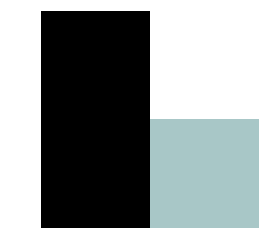

In [222]:
ax = pl.figure().add_subplot(111)
ax.imshow(confusion_matrix(y_test, y_pred), cmap='bone')
ax.axis('off')

print(('[["TP", "FP"], \n ["FN", "TN"]'))
print(confusion_matrix(y_test, y_pred))


# what if there are NaN?

In [163]:
bdata.isna().sum()

Nbuild     0
ppl        0
pcWhite    0
pcCitiz    0
pcPA       0
dtype: int64

there are no NaN observations in the data. Lets make some

In [164]:
bdata.iloc[10,2] = np.nan
bdata.iloc[30,1] = np.nan
bdata.iloc[20,2:3] = np.nan

bdata.isna().sum()

Nbuild     0
ppl        1
pcWhite    2
pcCitiz    0
pcPA       0
dtype: int64

In [165]:
bdata.shape

(45, 5)

In [166]:
#remove all rows with NaNs
bdata.dropna().shape

(42, 5)

In [167]:
#remove all columns with NaNs
bdata.dropna(axis=1).shape

(45, 3)

In [168]:
#backpropagate values that follow nan in a row
bdata.fillna(method="backfill", axis=0).shape

(45, 5)

In [181]:
bdata.iloc[29:32,0:4]

,Nbuild,ppl,pcWhite,pcCitiz
29,0.137949,0.538963,-0.220736,0.972662
30,-0.237181,NaN,-0.220736,-0.962379
31,-0.590338,-0.505054,-0.220736,-0.962379


In [182]:
#backward fill by column
bdata.fillna(method="backfill", axis=0).iloc[29:32,0:4]

,Nbuild,ppl,pcWhite,pcCitiz
29,0.137949,0.538963,-0.220736,0.972662
30,-0.237181,-0.505054,-0.220736,-0.962379
31,-0.590338,-0.505054,-0.220736,-0.962379


In [184]:
#pad with 0's
bdata.fillna(value=0).iloc[29:32,0:4]

,Nbuild,ppl,pcWhite,pcCitiz
29,0.137949,0.538963,-0.220736,0.972662
30,-0.237181,0.000000,-0.220736,-0.962379
31,-0.590338,-0.505054,-0.220736,-0.962379


**whatever you do is generally ok as long as you can and do justifiy your choice!**